# Unzipping the Pre-processed Data

In [1]:
# Unzip the contents of pre-processed data
# Allocate them into "/content/Kevin-MIE1517-processeddata"
# !unzip "/content/drive/MyDrive/Kevin-MIE1517-processeddata.zip" -d "/content/Kevin-MIE1517-processeddata"

In [55]:
# Import the necessary modules
# Important is torch.nn, torchvision, and DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [56]:
# Mount the device onto the GPU but if no GPU mount onto the CPU
# With GPU we have access to cuda capability, where we can parallelize the processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
# Define the image transformations
# Incoming images are 224x224
# Normalize them so that all data is same
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [58]:
# From where the pre-processed data was split into train, val, test
# Now define them into train_dataset, valid_dataset and test_dataset
# All of which are with batch size 32
data_dir = "Kevin-MIE1517-processeddata"
batch_size = 64 # changed from 32 to 64

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root=f"{data_dir}/valid", transform=image_transforms['valid'])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=image_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


# EfficientNet Model

In [64]:
# Define a class where we use frozen ResNet-152 model and just modify last layer to be
# a fully-connected layer where we have mutliclass-classification 1-196 different classes
# Note: we are only training on the classifier not on the frozen ResNet-152 prior layers
class EfficientNetWithClassifier(nn.Module):
    def __init__(self, num_classes=196, dropout_rate=0.6):
        super(EfficientNetWithClassifier, self).__init__()
        # load the pretrained EfficientNet model which is much better than resnet-152 with much less parameters
        self.backbone = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
        
        # freeze only the early layers (keep last few blocks trainable) 
        # this way we can train the last few blocks to classify the car models 
        # without affecting the pre-trained features and make our model more task-specific
        # this prevents overfitting and makes our model more generalizable

        ct = 0
        for child in self.backbone.features.children():
            ct += 1
            if ct < 7:  # freeze first 6 blocks
                for param in child.parameters():
                    param.requires_grad = False
        
        # get the number of features this is 1280 for efficientnet-v2-s
        num_features = self.backbone.classifier[1].in_features
        
        # enhanced classifier with batch normalization, dropout, and GELU activation
        # GELU performs better than ReLU activation function from experience
        # GELU is a smooth activation function that is similar to ReLU but with a slightly different shape
        # The smoother gradient helps with stabilizing the learning process and can lead to better performance
        # batch normalization helps with stabilizing the learning process
        # dropout helps with preventing overfitting

        self.classifier = nn.Sequential(
            # first block
            nn.BatchNorm1d(num_features),
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            
            # second block  
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            
            # third block
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            # final classification layer
            nn.Dropout(p=dropout_rate/2),  # lower dropout at final layer
            nn.Linear(256, num_classes)
        )
        
        # initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone.features(x)
        # global average pooling
        # we use global average pooling to reduce the spatial dimensions of the features
        # this helps with reducing the number of parameters and preventing overfitting
        features = self.backbone.avgpool(features)
        features = torch.flatten(features, 1)
        # apply classifier
        return self.classifier(features)

In [65]:
efficientnet_model = EfficientNetWithClassifier(num_classes=196).to(device)

# count the number of blocks
num_blocks = len(list(efficientnet_model.backbone.features.children()))
print(f"\nTotal number of blocks: {num_blocks}")

# print which blocks are frozen vs trainable
print("\nTraining Status of Blocks:")
for i, layer in enumerate(efficientnet_model.backbone.features.children()):
    trainable_params = any(p.requires_grad for p in layer.parameters())
    print(f"Block {i + 1}: {'Trainable' if trainable_params else 'Frozen'}")


Total number of blocks: 8

Training Status of Blocks:
Block 1: Frozen
Block 2: Frozen
Block 3: Frozen
Block 4: Frozen
Block 5: Frozen
Block 6: Frozen
Block 7: Trainable
Block 8: Trainable


In [66]:
# Instantiate the EfficientNet model with enhanced regularization
efficientnet_model = EfficientNetWithClassifier(
    num_classes=196,
    dropout_rate=0.5  # Return to 0.5 but add more regularization elsewhere
).to(device)

# Gradient clipping (keep as is)
torch.nn.utils.clip_grad_norm_(efficientnet_model.parameters(), max_norm=1.0)
num_epochs = 15  # Reduce epochs to prevent overfitting

# Enhanced optimizer settings with stronger regularization
optimizer = optim.AdamW(
    efficientnet_model.parameters(),
    lr=0.0003,  # Lower initial learning rate
    weight_decay=0.08,  # Increased weight decay
    betas=(0.9, 0.999),
    eps=1e-8
)

# Modified learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0006,  # Lower max learning rate
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # Shorter warmup
    div_factor=20,
    final_div_factor=1000,
    anneal_strategy='cos'
)

# Enhanced loss function with stronger regularization
criterion = nn.CrossEntropyLoss(
    label_smoothing=0.15
)

# Add mixup augmentation
mixup = True
mixup_alpha = 0.2

# Add stochastic depth
stochastic_depth_prob = 0.2

In [67]:
from sklearn.metrics import f1_score

def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, patience=5):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    train_f1_scores = []
    valid_f1_scores = []
    best_accuracy = 0
    best_f1 = 0
    best_epoch = 0
    scaler = torch.amp.GradScaler()

    # Early stopping variables
    patience_counter = 0
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_preds = []
        train_labels_list = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision training
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Scale and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            
            # Calculate training accuracy and collect predictions
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())

            # Step the scheduler
            scheduler.step()

        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_f1 = f1_score(train_labels_list, train_preds, average='weighted')
        train_f1_scores.append(train_f1)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        valid_preds = []
        valid_labels_list = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
                valid_preds.extend(predicted.cpu().numpy())
                valid_labels_list.extend(labels.cpu().numpy())

        # Calculate validation metrics
        epoch_valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)
        valid_accuracy = correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)
        valid_f1 = f1_score(valid_labels_list, valid_preds, average='weighted')
        valid_f1_scores.append(valid_f1)

        # Save best model and update early stopping variables
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_f1 = valid_f1
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_accuracy': valid_accuracy,
                'valid_f1': valid_f1,
            }, 'best_efficientnet_v2_s.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")
        print(f"Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
        print(f"Train F1: {train_f1:.4f}, Valid F1: {valid_f1:.4f}")
        print(f"Best Accuracy: {best_accuracy:.4f} (Epoch {best_epoch})")
        print(f"Early Stopping Counter: {patience_counter}/{patience}")
        print("-" * 60)

        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            print(f"Best model was saved at epoch {best_epoch}")
            break

    # Load best model
    checkpoint = torch.load('best_efficientnet_v2_s.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Final best model results
    print(f"\nTraining completed after {epoch+1} epochs")
    print(f"Best Validation Accuracy: {best_accuracy:.4f} (Epoch {best_epoch})")
    print(f"Best Validation F1-Score: {best_f1:.4f}")

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Loss plot
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    ax1.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    ax2.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Validation Accuracy')
    ax2.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    ax2.set_title('Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # F1 Score plot
    ax3.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1')
    ax3.plot(range(1, len(valid_f1_scores) + 1), valid_f1_scores, label='Validation F1')
    ax3.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    ax3.set_title('F1 Score per Epoch')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 1/15
Training Loss: 5.8200, Validation Loss: 4.9638
Train Accuracy: 0.0075, Valid Accuracy: 0.0593
Train F1: 0.0068, Valid F1: 0.0350
Best Accuracy: 0.0593 (Epoch 1)
Early Stopping Counter: 0/5
------------------------------------------------------------
Epoch 2/15
Training Loss: 4.4228, Validation Loss: 2.9947
Train Accuracy: 0.1283, Valid Accuracy: 0.4561
Train F1: 0.1200, Valid F1: 0.4289
Best Accuracy: 0.4561 (Epoch 2)
Early Stopping Counter: 0/5
------------------------------------------------------------
Epoch 3/15
Training Loss: 2.5588, Validation Loss: 2.1734
Train Accuracy: 0.6024, Valid Accuracy: 0.7180
Train F1: 0.5987, Valid F1: 0.7055
Best Accuracy: 0.7180 (Epoch 3)
Early Stopping Counter: 0/5
------------------------------------------------------------
Epoch 4/15
Training Loss: 1.8308, Validation Loss: 2.0081
Train Accuracy: 0.8742, Valid Accuracy: 0.7925
Train F1: 0.8739, Valid F1: 0.7857
Best Accuracy: 0.7925 (Epoch 4)
Early Stopping Counter: 0/5
-----------------

/tmp/ipykernel_2507098/1340475986.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_efficientnet_v2_s.pth')



Training completed after 15 epochs
Best Validation Accuracy: 0.8820 (Epoch 15)
Best Validation F1-Score: 0.8795


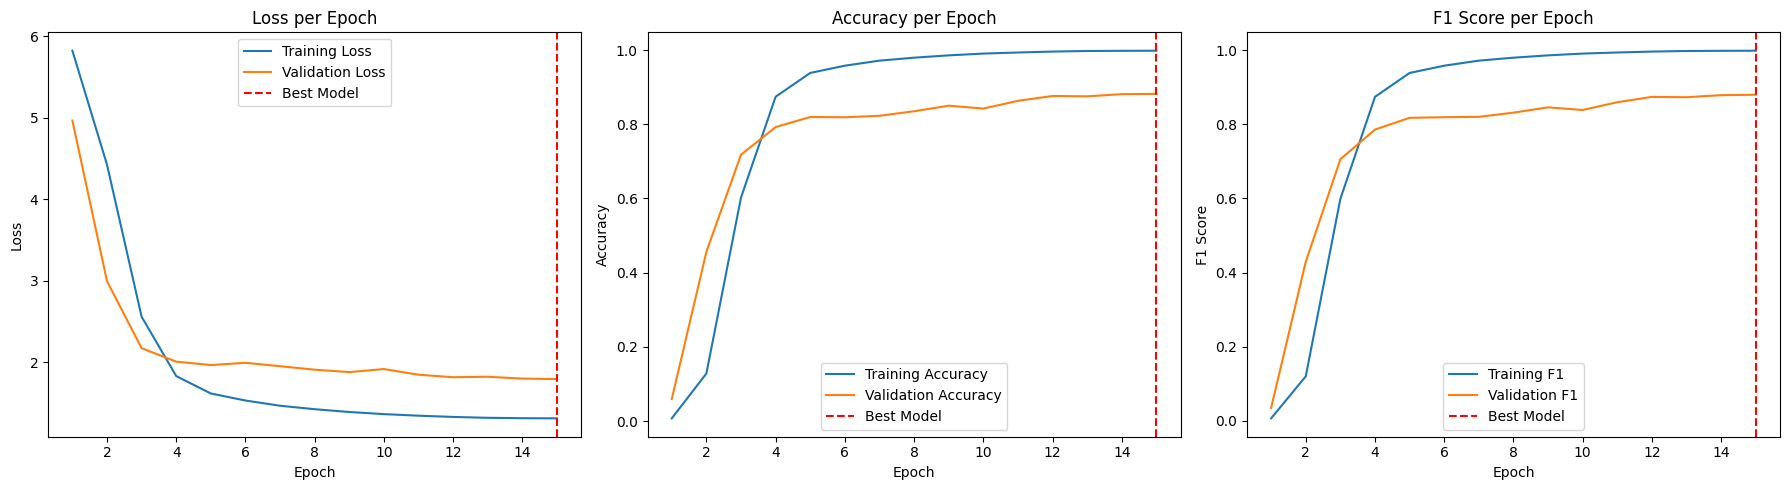

In [68]:
# Required using Colab Pro with A100 GPU with 80 GB RAM and 40 GB VRAM
# 10 epochs trained on
# Note: model takes in ResNet-152 model, trains, validates it (notice how no test data)
efficientnet_model = train_model(efficientnet_model, 
                                 criterion, 
                                 optimizer, 
                                 scheduler, 
                                 train_loader, 
                                 valid_loader, 
                                 num_epochs, 
                                 patience=5)


# ResNet-152

In [12]:
class ResNet152WithClassifier(nn.Module):  # Renamed class to match architecture
    def __init__(self, num_classes=196, dropout_rate=0.3):
        super(ResNet152WithClassifier, self).__init__()
        # load pretrained ResNet152
        self.backbone = models.resnet152('DEFAULT')
        
        # freeze early layers
        ct = 0
        for child in self.backbone.children():
            ct += 1
            if ct < 7:  # freeze first 6 blocks
                for param in child.parameters():
                    param.requires_grad = False
        
        # get number of features from ResNet152's final FC layer
        num_features = self.backbone.fc.in_features
        
        # Remove the original FC layer
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            # first block
            nn.BatchNorm1d(num_features),
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            
            # second block  
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            
            # third block
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            # final classification layer
            nn.Dropout(p=dropout_rate/2),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Use the full ResNet backbone
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        return self.classifier(x)

In [7]:
# Mount the device onto the GPU but if no GPU mount onto the CPU
# With GPU we have access to cuda capability, where we can parallelize the processing
resnet_model = ResNet152WithClassifier(num_classes=196).to(device)

# print the backbone features
print("\nBackbone Features:")
for i, layer in enumerate(resnet_model.backbone.children()):
    print(f"Block {i + 1}:")
    print(layer)

# print which blocks are frozen vs trainable
print("\nTraining Status of Blocks:")
for i, layer in enumerate(resnet_model.backbone.children()):
    trainable_params = any(p.requires_grad for p in layer.parameters())
    print(f"Block {i + 1}: {'Trainable' if trainable_params else 'Frozen'}")


/home/asblab8/miniconda3/envs/car/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(



Backbone Features:
Block 1:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Block 2:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Block 3:
ReLU(inplace=True)
Block 4:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Block 5:
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [13]:
# Define the criterion as CrossEntropyLoss() as this is a multiclass-classification problem
# Set the opitmizer to be the Adam optimizer with learning rate of 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import time


# Define the training code
# Here we are both training and validating and updating the parameters of the ResNetWithClassifier() model
# We also modified it so that afterwards the training, validation loss as well as the validation accuracy is shown
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path="best_model_resnet152.pth"):
    # Ensure the directory for saving the model exists
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_accuracy = 0.0
    best_f1 = 0.0
    best_epoch = 0

    # Track total training time
    start_time = time.time()

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        epoch_start_time = time.time()  # Track time for each epoch
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        train_accuracy = correct_train / total_train  # Calculate training accuracy
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

                # Collect predictions and labels for F1-score
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        valid_accuracy = correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        # Compute F1-score
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Check if this is the best model so far
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            best_f1 = epoch_f1
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model weights

        # Print epoch results
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, F1-Score: {epoch_f1:.4f}")

    # Calculate total training time
    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal Training Time: {total_time:.2f} seconds")

    # Display the best results
    print(f"\nBest Validation Accuracy: {best_accuracy:.4f} at Epoch {best_epoch}")
    print(f"Best Validation F1-Score: {best_f1:.4f} at Epoch {best_epoch}")

    # Plotting after all epochs are completed
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title('Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [10]:
# Required using Colab Pro with A100 GPU with 80 GB RAM and 40 GB VRAM
# 10 epochs trained on
# Note: model takes in ResNet-152 model, trains, validates it (notice how no test data)
num_epochs = 10
train_model(resnet_model, criterion, optimizer, train_loader, valid_loader, num_epochs)

epoch:  0
Epoch 1/10 took 450.68 seconds
Epoch 1/10
Training Loss: 0.4084, Validation Loss: 0.7441, Train Accuracy: 0.8790, Valid Accuracy: 0.7866, F1-Score: 0.7806
epoch:  1


KeyboardInterrupt: 

Still need to be done to complete the project:

(1) Baseline Model

(2) Hyperparameter Tuning

(3) Testing on the test set

(4) Inference on Self-curated images or video frames


In [ ]:


!jupyter nbconvert --to html /content/commented_MIE1517_group3_project_model.ipynb